## Billboard crossing problem
### Author: Zhiji Ding
### Data preparation

In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv('/Users/jimmyding/Downloads/device_road_section_sample.csv')
df=df.sort_values(by=['device_id','event_ts'])
df.reset_index(drop=True, inplace=True)
df.head()

,lat,long,event_ts,poi_lat,poi_long,poi_name,poi_sequence,device_id
0,49.031128,-122.834470,2018-10-01 17:38:20 UTC,49.031193,-122.829585,7_1,-1,0
1,49.031250,-122.830660,2018-10-01 17:38:41 UTC,49.031193,-122.829585,7_1,-1,0
2,49.031250,-122.830660,2018-10-01 17:38:42 UTC,49.031193,-122.829585,7_1,-1,0
3,49.031250,-122.830605,2018-10-01 17:38:44 UTC,49.031193,-122.829585,7_1,-1,0
4,49.031250,-122.829180,2018-10-01 17:38:49 UTC,49.031193,-122.829585,7_1,-1,0


In [2]:
df.isnull().any().any()

False

In [3]:
df.isna().any().any()

False

In [6]:
# create groupby object for iteration over all the devices
device_group=df.groupby('device_id')


In [7]:
# define function to transform the dataframe into callable form.

import utm

def create_count(df):

# calculate time interval between each read
    df['time_interval']=pd.to_datetime(df['event_ts']).diff()

# calculate distance between each read
    
    try:
        for i, row in df.iterrows():
            df.loc[i+1, 'distance'] = utm.from_latlon(df['lat'][i],df['long'][i])[0] - \
            utm.from_latlon(df['lat'][i+1],df['long'][i+1])[0]
    except:
        ValueError

# replace na value
    df['time_interval'].fillna(pd.Timedelta(seconds=0), inplace=True)
    df['distance'].fillna(0,inplace=True)


# subset sequences only
    df_subset=df.loc[(df['poi_sequence'] != df['poi_sequence'].shift(-1)) | \
                   (df['poi_sequence'] != df['poi_sequence'].shift(1)) | \
                   (df['poi_sequence']==0)]
    df_subset.reset_index(inplace=True)
    
# create new dataframe to store data    
    ct=pd.DataFrame(columns=['sequence','time_spent','time_of_day','distance','velocity'])
    n=0   # index of each sequence
    ct.loc[n,'sequence']=[]
    ct.loc[n,'time_spent']=[]
    ct.loc[n,'time_of_day']=[]
    ct.loc[n,'distance']=[]
    for i in range(0,len(df_subset)-1):
        if df_subset.loc[i,'time_interval'].total_seconds()< 7200:    # A traffic jam or lunch break of up to 2 hours is assumed acceptable.
            ct.loc[n,'sequence'].append(df_subset.loc[i,'poi_sequence'])  # create each board crossing sequence into lists.
            ct.loc[n,'time_spent'].append(df_subset.loc[i,'time_interval'].total_seconds()) # store time interval into lists.
            ct.loc[n,'time_of_day'].append(df_subset.loc[i,'event_ts'])   # store time of the sequence.
            ct.loc[n,'distance'].append(df_subset.loc[i,'distance'])      # store distance
# decide when to stop a sequence        
        if (df_subset.loc[i+1,'index'] - df_subset.loc[i,'index']>1) | \
        (df_subset.loc[i,'time_interval'].total_seconds() >= 7200) |\
        ((df_subset.loc[i+1,'poi_sequence']==df_subset.loc[i,'poi_sequence']) & \
        df_subset.loc[i,'poi_sequence']!=0):
            ct.loc[n,'time_spent']=sum(ct.loc[n,'time_spent'][1:])
            ct.loc[n,'distance']=sum(ct.loc[n,'distance'][1:])
            ct.loc[n,'velocity']=ct.loc[n,'distance']/(ct.loc[n,'time_spent']+0.00001)*3.6  # calculation of velocity for Q3
            n=n+1
            ct.loc[n,'sequence']=[]
            ct.loc[n,'time_spent']=[]
            ct.loc[n,'time_of_day']=[]
            ct.loc[n,'distance']=[]
    ct = ct[ct['time_spent']!=0]
    ct= ct.iloc[:-1,:]  # remove the last row of empty list
    
    for i, row in ct.iterrows():
        ct.loc[i,'time_of_day']=[ct.loc[i,'time_of_day'][0],ct.loc[i,'time_of_day'][-1]] # add starting/ending time of the sequence
        if row['sequence'][-1]-row['sequence'][0] >0:  # determine direction of driving
            ct.loc[i,'direction']='E'
        else:
            ct.loc[i,'direction']='W'
    return ct


In [8]:
pd.set_option('mode.chained_assignment', None)
dfcount=pd.DataFrame(columns=['sequence','time_spent','time_of_day','direction','device_id'])

for i in range(len(device_group)):    
    df_group=device_group.get_group(i)    
    df_count=create_count(df_group)
    df_count['device_id']=i
    dfcount=pd.concat([dfcount,df_count],ignore_index=True, sort=True)
    
dfcount.head(5)  


,device_id,direction,distance,sequence,time_of_day,time_spent,velocity
0,0,E,-369.846,"[-1, 1]","[2018-10-01 17:39:00 UTC, 2018-10-01 17:39:17 ...",17,-78.3203
1,0,W,353.789,"[1, -1]","[2018-10-01 17:56:54 UTC, 2018-10-01 17:57:09 ...",15,84.9092
2,0,E,-544.586,"[-1, 1]","[2018-10-02 17:35:42 UTC, 2018-10-02 17:36:08 ...",26,-75.4042
3,0,W,1061.39,"[1, 0, -1]","[2018-10-02 18:12:08 UTC, 2018-10-02 18:13:25 ...",77,49.6234
4,0,E,-173.231,"[-1, 1]","[2018-10-04 23:55:38 UTC, 2018-10-04 23:55:50 ...",12,-51.9693


# Q1
## a)

In [9]:
# Total number of trips
dfcount.groupby(['direction'])['device_id'].count()

direction
E    1536
W    1131
Name: device_id, dtype: int64

In [10]:
# Total number of devices
dfcount.groupby(['direction'])['device_id'].nunique()

direction
E    416
W    294
Name: device_id, dtype: int64

## b)

In [11]:
print('Average #trips per device travelling eastwards:', 1536/416)
print('Average #trips per device travelling westwards:', 1131/294)

Average #trips per device travelling eastwards: 3.6923076923076925
Average #trips per device travelling westwards: 3.8469387755102042


In [12]:
df_device=pd.DataFrame(dfcount.groupby(['device_id','direction'])['sequence'].count())
df_device.rename(columns={"sequence": "trip_count"},inplace=True)
df_device.reset_index(inplace=True)
df_device.head()

,device_id,direction,trip_count
0,0,E,11
1,0,W,9
2,1,E,1
3,1,W,1
4,2,E,11


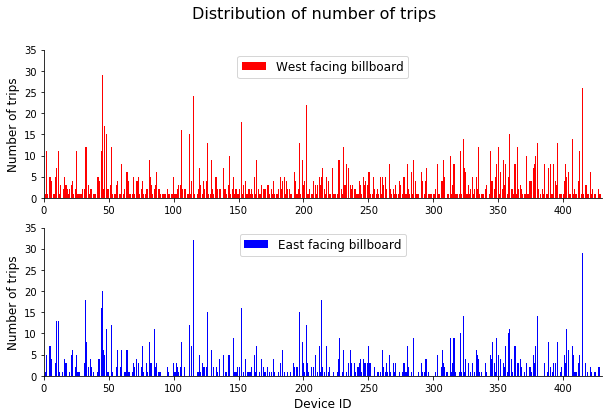

In [14]:
# directly plot # trips for each device

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,figsize=(10,6))
fig.suptitle('Distribution of number of trips', fontsize=16)

# plot west facing board
axs[0].bar(df_device['device_id'][df_device['direction']=='E'],df_device['trip_count'][df_device['direction']=='E'],color='r', label='West facing billboard')
axs[0].axis([0, 430, 0, 35])
axs[0].tick_params(axis='both', which='major', labelsize=10)
#axs[0].set_xlabel('Device ID', fontsize=20)
axs[0].set_ylabel('Number of trips', fontsize=12)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].legend(fontsize=12,loc='upper center')

# plot east facing board
axs[1].bar(df_device['device_id'][df_device['direction']=='W'],df_device['trip_count'][df_device['direction']=='W'],color='b', label='East facing billboard')
axs[1].axis([0, 430, 0, 35])
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_xlabel('Device ID', fontsize=12)
axs[1].set_ylabel('Number of trips', fontsize=12)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].legend(fontsize=12,loc='upper center')

plt.show()

### However this doesn't give much information. 
### Actually device id is not important rather the distribution of the number makes more sense. So I use boxplot to visualize the distribution of number of trips per device. Alternatively histogram can also be applied for the same purpose.


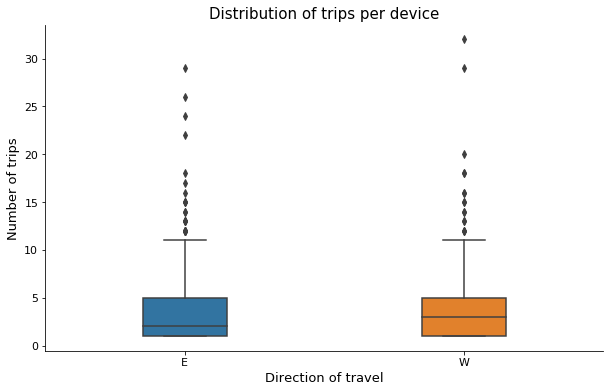

In [15]:
import seaborn as sns
plt.figure(figsize=(10, 6))
bx = sns.boxplot(y='trip_count', x='direction', 
                 data=df_device, 
                 width=0.3,
                 )
bx.axes.set_title("Distribution of trips per device",fontsize=15)
bx.set_xlabel("Direction of travel",fontsize=13)
bx.set_ylabel("Number of trips",fontsize=13)
bx.tick_params(labelsize=11)
bx.spines['top'].set_visible(False)
bx.spines['right'].set_visible(False)



### Trips are dominated by "occasionally" passed by devices, which is beneficial because the billboards are exposed to more people
### Upper outliers are frequent travellers, presumably residents nearby commuting to work.

# Q2

In [16]:
pd.set_option('display.max_colwidth', -1)
df_day=dfcount  # assign to another dataframe

In [17]:
df_day['start']=df_day.apply(lambda x: x['time_of_day'][0],axis=1)
df_day['end']=df_day.apply(lambda x: x['time_of_day'][1],axis=1)

# convert strings to timestamps
df_day['start']=pd.to_datetime(df_day['start'])
df_day['end']=pd.to_datetime(df_day['end'])

# Assumption: center of the time interval travelling through the sequence is the time the device past the billboard
df_day['time_of_day']=df_day.apply(lambda x: x['start']+(x['start']-x['end'])/2, axis=1)
df_day.head()

,device_id,direction,distance,sequence,time_of_day,time_spent,velocity,start,end
0,0,E,-369.846,"[-1, 1]",2018-10-01 17:38:51.500000+00:00,17,-78.3203,2018-10-01 17:39:00+00:00,2018-10-01 17:39:17+00:00
1,0,W,353.789,"[1, -1]",2018-10-01 17:56:46.500000+00:00,15,84.9092,2018-10-01 17:56:54+00:00,2018-10-01 17:57:09+00:00
2,0,E,-544.586,"[-1, 1]",2018-10-02 17:35:29+00:00,26,-75.4042,2018-10-02 17:35:42+00:00,2018-10-02 17:36:08+00:00
3,0,W,1061.39,"[1, 0, -1]",2018-10-02 18:11:29.500000+00:00,77,49.6234,2018-10-02 18:12:08+00:00,2018-10-02 18:13:25+00:00
4,0,E,-173.231,"[-1, 1]",2018-10-04 23:55:32+00:00,12,-51.9693,2018-10-04 23:55:38+00:00,2018-10-04 23:55:50+00:00


In [18]:
# convert UTC time to local time. The timezone was determined by locating the coordinate on Google map. 

import pytz
tz = pytz.timezone('America/Vancouver')
df_day['crossing_time']=df_day.apply(lambda x: x['time_of_day'].astimezone(tz), axis=1)

df_day.head()

,device_id,direction,distance,sequence,time_of_day,time_spent,velocity,start,end,crossing_time
0,0,E,-369.846,"[-1, 1]",2018-10-01 17:38:51.500000+00:00,17,-78.3203,2018-10-01 17:39:00+00:00,2018-10-01 17:39:17+00:00,2018-10-01 10:38:51.500000-07:00
1,0,W,353.789,"[1, -1]",2018-10-01 17:56:46.500000+00:00,15,84.9092,2018-10-01 17:56:54+00:00,2018-10-01 17:57:09+00:00,2018-10-01 10:56:46.500000-07:00
2,0,E,-544.586,"[-1, 1]",2018-10-02 17:35:29+00:00,26,-75.4042,2018-10-02 17:35:42+00:00,2018-10-02 17:36:08+00:00,2018-10-02 10:35:29-07:00
3,0,W,1061.39,"[1, 0, -1]",2018-10-02 18:11:29.500000+00:00,77,49.6234,2018-10-02 18:12:08+00:00,2018-10-02 18:13:25+00:00,2018-10-02 11:11:29.500000-07:00
4,0,E,-173.231,"[-1, 1]",2018-10-04 23:55:32+00:00,12,-51.9693,2018-10-04 23:55:38+00:00,2018-10-04 23:55:50+00:00,2018-10-04 16:55:32-07:00


In [19]:
# extracting information on day and hour
df_day=df_day.loc[:,['device_id','direction','crossing_time']]
df_day['day']=df_day['crossing_time'].dt.date
df_day['hour']=df_day['crossing_time'].dt.hour
df_day.drop(['crossing_time'],axis=1, inplace=True)
df_day=df_day.sort_values(by=['direction','day','hour'])

In [20]:
# count #trips per day for each board
df_day_count=pd.DataFrame(df_day.groupby(['direction','day','hour'])['device_id'].count())
df_day_count.reset_index(inplace=True)
df_day_count.rename(columns={"device_id": "trip_count"},inplace=True)
df_day_count.head()

,direction,day,hour,trip_count
0,E,2018-09-30,19,2
1,E,2018-10-01,5,1
2,E,2018-10-01,6,2
3,E,2018-10-01,7,3
4,E,2018-10-01,8,10


In [21]:
# Split into two dataframe for each direction for simplicity
# Days in September are removed because it might be incomplete.
df_day_E= df_day_count[df_day_count['direction']=='E'].reset_index(drop=True).loc[1:,:]
df_day_W= df_day_count[df_day_count['direction']=='W'].reset_index(drop=True).loc[3:,:]

In [22]:
df_day_E.head()

,direction,day,hour,trip_count
1,E,2018-10-01,5,1
2,E,2018-10-01,6,2
3,E,2018-10-01,7,3
4,E,2018-10-01,8,10
5,E,2018-10-01,9,2


In [23]:
df_day_W.head()

,direction,day,hour,trip_count
3,W,2018-10-01,8,6
4,W,2018-10-01,9,1
5,W,2018-10-01,10,2
6,W,2018-10-01,12,2
7,W,2018-10-01,14,3


In [24]:
# Calculate number of trips for each hour averaged over the whole month

day_E=pd.DataFrame(df_day_E.groupby(['hour'])['trip_count'].sum()/31).reset_index()
day_W=pd.DataFrame(df_day_W.groupby(['hour'])['trip_count'].sum()/31).reset_index()

<function matplotlib.pyplot.show(*args, **kw)>

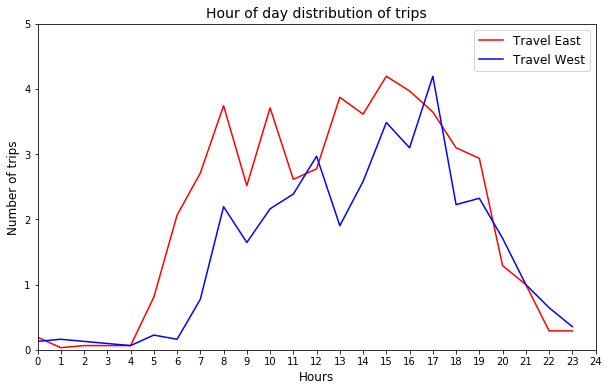

In [25]:
plt.figure(figsize=(10, 6))

plt.plot(day_E['hour'],day_E['trip_count'], color='red', label='Travel East')
plt.plot(day_W['hour'],day_W['trip_count'], color = 'blue', label = 'Travel West')

plt.axis([0, 24, 0, 5])

plt.xlabel('Hours', fontsize=12)
plt.ylabel('Number of trips',fontsize=12)
plt.tick_params(labelsize=10)
plt.xticks(np.arange(0,25,1))
plt.title('Hour of day distribution of trips', fontsize=14)
plt.legend(fontsize=12)

plt.grid(False)
plt.show

### Peak hours are in day time. For westward traveller, around 5 p.m is the peak hour. For eastward traveller, around 3 p.m is the peak hour.

# Q3
### Velocity is calculated as total distance travelled divided by the total time spent for each sequence that considered past the billboard (in dataframe "dfcount"). Negative values are caused by the direction. The detailed calculation could be found in the create_count function above.

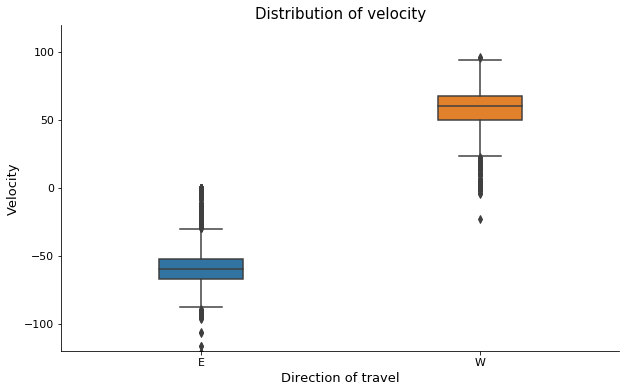

In [28]:
plt.figure(figsize=(10, 6))
dfcount['velocity']=dfcount['velocity'].astype(float)
bx = sns.boxplot(y='velocity', x='direction', 
                 data=dfcount, 
                 width=0.3,
                 )
bx.axes.set_title("Distribution of velocity",fontsize=15)
bx.set_xlabel("Direction of travel",fontsize=13)
bx.set_ylabel("Velocity",fontsize=13)
bx.set_ylim([-120,120])
bx.tick_params(labelsize=11)
bx.spines['top'].set_visible(False)
bx.spines['right'].set_visible(False)


### From the boxplot, we could see that velocities higher than 100km/h and lower than 20 are considered outliers. This is not only because statistics tell us that but also common knowledge for car speed on a regular city road. The presence of extremely high velocity is caused by the handling of zero division in the creat_count function and is excluded from the plot.

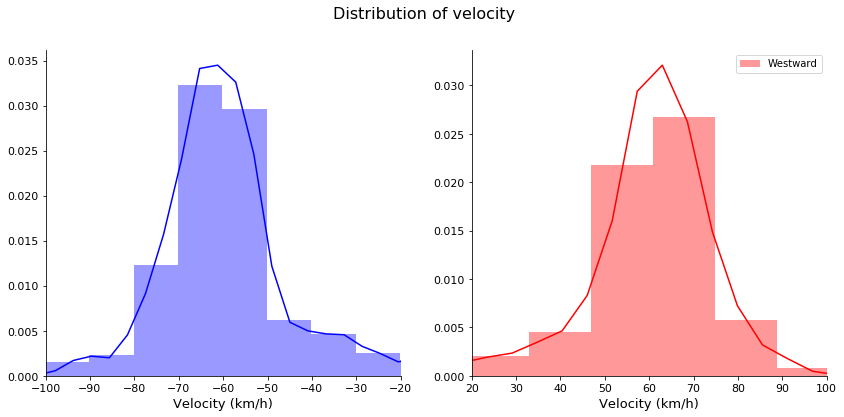

In [29]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
fig.suptitle('Distribution of velocity', fontsize=16)
sns.distplot(dfcount[dfcount['direction']=='E']['velocity'], color="blue", ax=axs[0])
sns.distplot(dfcount[dfcount['direction']=='W']['velocity'], color="red", ax=axs[1])

axs[0].set(xlim=(-100, -20))
axs[0].set_xlabel("Velocity (km/h)",fontsize=13)
axs[0].tick_params(labelsize=11)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
plt.legend(loc='upper left', labels=['Eastward'])

axs[1].set(xlim=(20, 100))
axs[1].set_xlabel("Velocity (km/h)",fontsize=13)
axs[1].tick_params(labelsize=11)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
plt.legend(loc='upper right', labels=['Westward'])

### A peak at low speed towards zero can be explained by either walking devices or traffic jams. Since they are minor cases in this example, they are also considered as outliers.
### Other than the outliers, the distribution is as expected as normally distributed for both directions.

# Q4
### Since the uncertainty of the GPS coordinates is only in y-direction (northing), the uncertainty actually means the device is not travelling on the targeted road but a parell road instead.

In [30]:
# Calculation of distance on y direction between the recorded gps coordinates and center of road position
df['y_div']=df.apply(lambda x: utm.from_latlon(x['lat'],x['long'])[1]-utm.from_latlon(x['poi_lat'],x['poi_long'])[1],\
                     axis=1)
df.head()

,lat,long,event_ts,poi_lat,poi_long,poi_name,poi_sequence,device_id,y_div
0,49.031128,-122.834470,2018-10-01 17:38:20 UTC,49.031193,-122.829585,7_1,-1,0,-8.002491
1,49.031250,-122.830660,2018-10-01 17:38:41 UTC,49.031193,-122.829585,7_1,-1,0,6.174252
2,49.031250,-122.830660,2018-10-01 17:38:42 UTC,49.031193,-122.829585,7_1,-1,0,6.174252
3,49.031250,-122.830605,2018-10-01 17:38:44 UTC,49.031193,-122.829585,7_1,-1,0,6.183225
4,49.031250,-122.829180,2018-10-01 17:38:49 UTC,49.031193,-122.829585,7_1,-1,0,6.416733


In [32]:
# Type A estimate of the uncertainty of the measurement

from statistics import mean, stdev
#mean(df['y_div'])
sd_records = stdev(df['y_div'])
print(sd_records)

4.21022695580194


In [33]:
# Calculation of combined uncertainty in standard deviation:
from math import sqrt
Uc= sqrt(sd_records**2+(50/2)**2)   # a coverage factor of 2 is assumed to be included in the uncertainty of gps coordinate.
Uc

25.352041555254704

In [34]:
from scipy.stats import norm
N=norm(mean(df['y_div']),Uc*2)
print('Uncertainty: ',1-(N.cdf(20)-N.cdf(-20)))

Uncertainty:  0.6933458998393898


### The uncertainty for the number of trips and number of devices is expressed in percentage that the device might be off the road, which is 43%.